In [68]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [70]:
# Step 2: Load Dataset
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\cyber secqurity suspecious threat\cybersecurity_data.csv.csv")
print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [72]:
# Step 3: Data Cleaning and Preparation
df = df.drop_duplicates()
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])
df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()


In [74]:
# Step 4: Feature Engineering
df['duration_seconds'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['bytes_in', 'bytes_out', 'duration_seconds']])
scaled_df = pd.DataFrame(scaled, columns=['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds'])
# One-hot encode the src_ip_country_code
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(df[['src_ip_country_code']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['src_ip_country_code']))

df_transformed = pd.concat([df.reset_index(drop=True), scaled_df, encoded_df], axis=1)


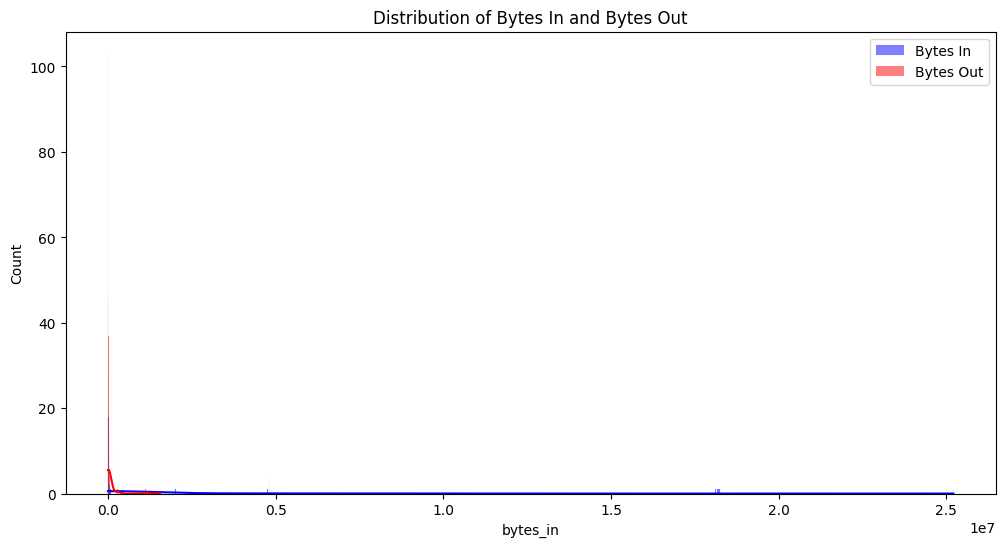

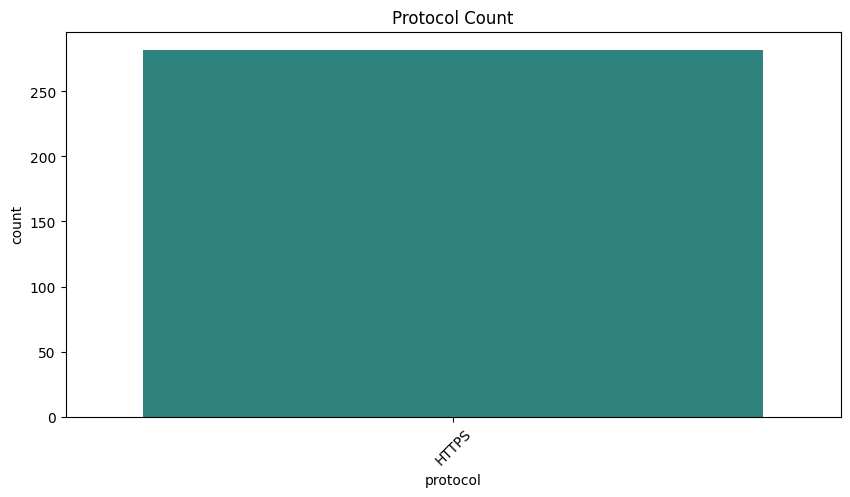

In [50]:
# Step 5: Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.histplot(df['bytes_in'], kde=True, color='blue', label='Bytes In')
sns.histplot(df['bytes_out'], kde=True, color='red', label='Bytes Out')
plt.legend()
plt.title('Distribution of Bytes In and Bytes Out')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x='protocol', data=df, palette='viridis')
plt.title('Protocol Count')
plt.xticks(rotation=45)
plt.show()

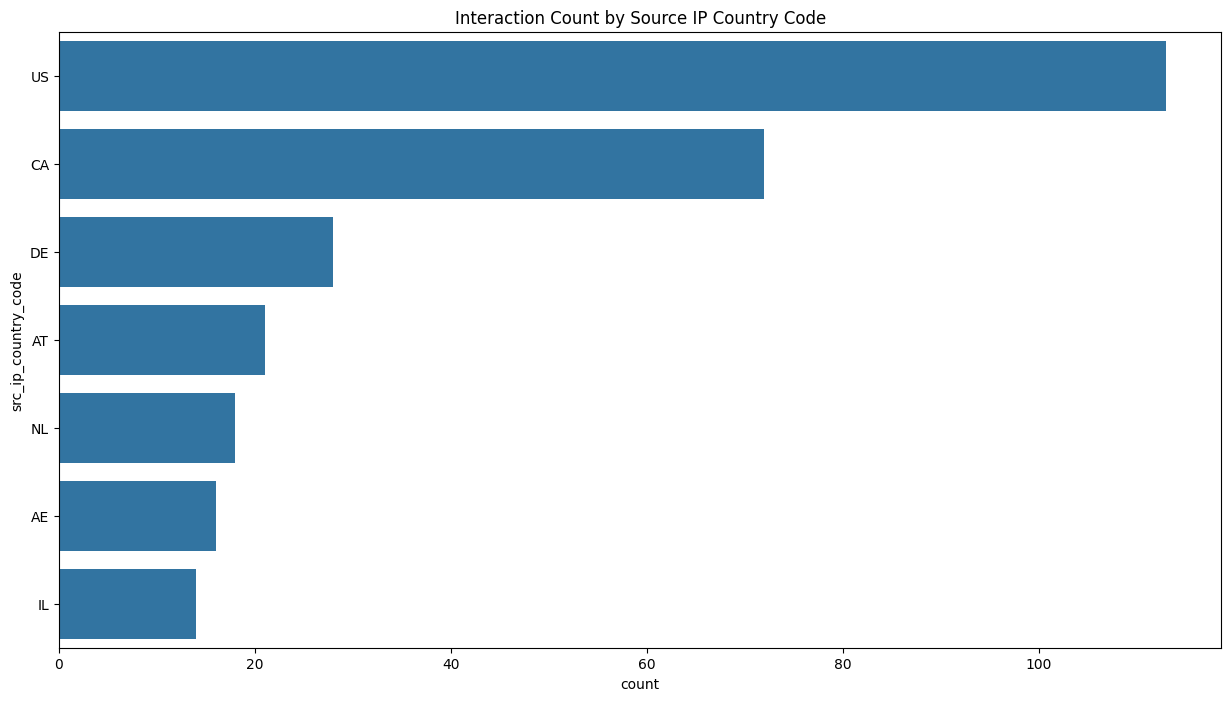

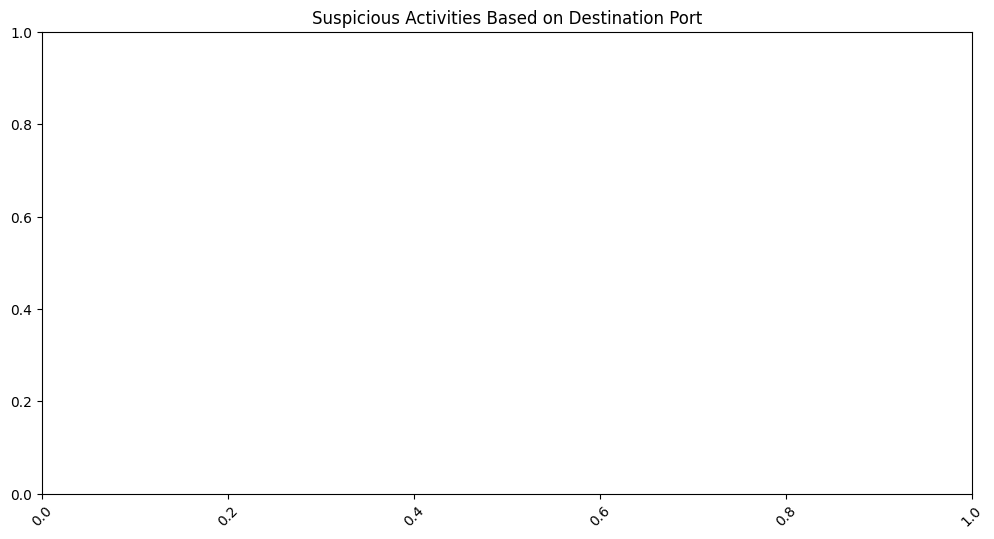

In [ ]:
# Step 6: countplot
plt.figure(figsize=(15, 8))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index)
plt.title('Interaction Count by Source IP Country Code')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='dst_port', data=df[df['detection_types'] == 'Suspicious'], palette='coolwarm')
plt.title('Suspicious Activities Based on Destination Port')
plt.xticks(rotation=45)
plt.show()

In [54]:
# Step 7: Anomaly Detection using Isolation Forest
features = df[['bytes_in', 'bytes_out', 'duration_seconds']]
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = model.fit_predict(features)
df['anomaly'] = df['anomaly'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')

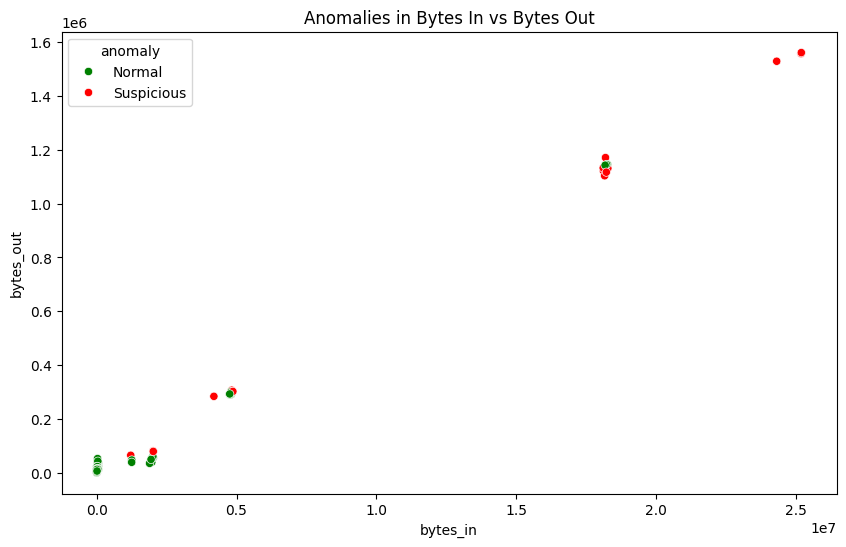

In [56]:
# Step 8: Visualize Anomalies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df, palette=['green', 'red'])
plt.title('Anomalies in Bytes In vs Bytes Out')
plt.show()


In [58]:
# Step 9: Classification with Random Forest
df_transformed['is_suspicious'] = (df_transformed['detection_types'] == 'waf_rule').astype(int)
X = df_transformed[['bytes_in', 'bytes_out', 'scaled_duration_seconds']]
y = df_transformed['is_suspicious']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



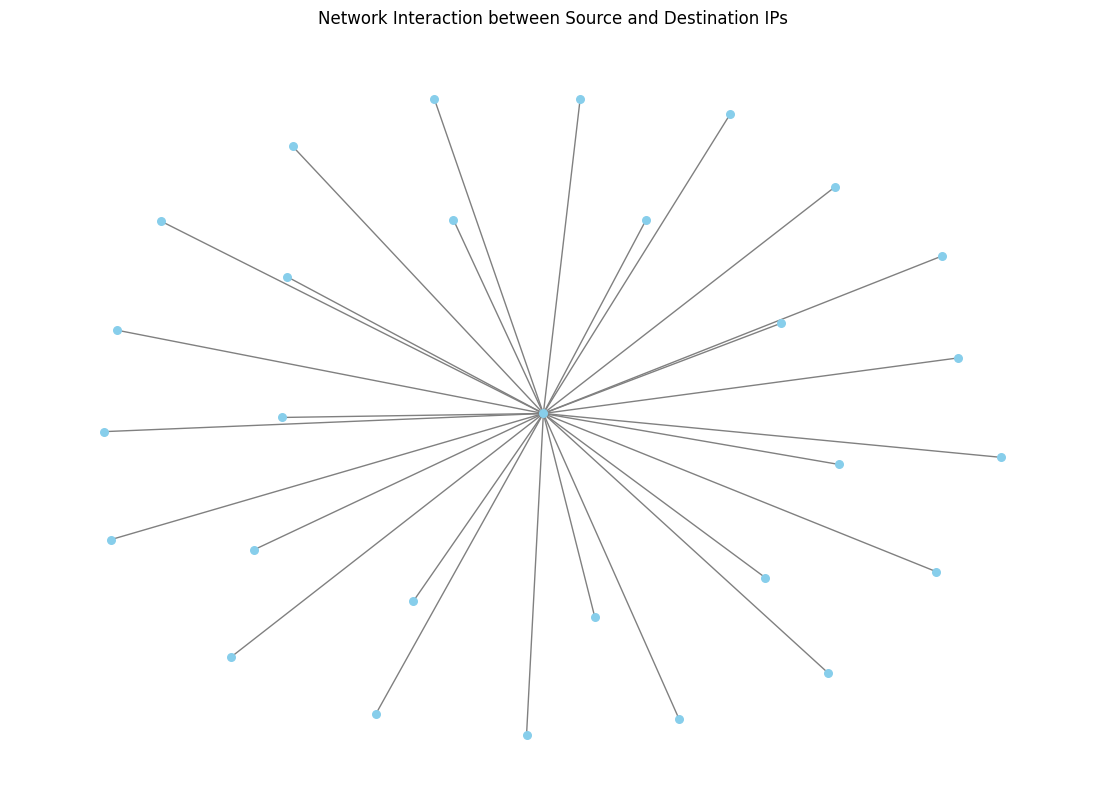

In [60]:
# Step 10: Graph-Based Network Visualization
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_edge(row['src_ip'], row['dst_ip'])
plt.figure(figsize=(14, 10))
nx.draw_networkx(G, with_labels=False, node_size=30, node_color='skyblue', edge_color='gray')
plt.title('Network Interaction between Source and Destination IPs')
plt.axis('off')
plt.show()

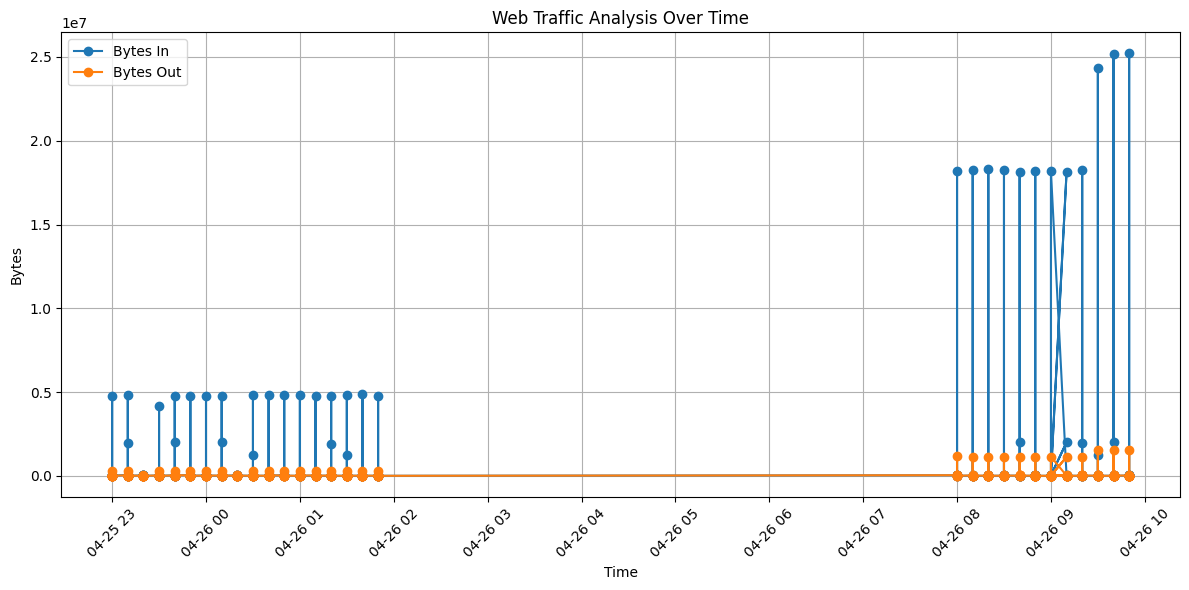

In [62]:
# Step 11: Time Series Analysis
plt.figure(figsize=(12, 6))
df.set_index('creation_time', inplace=True)
plt.plot(df.index, df['bytes_in'], label='Bytes In', marker='o')
plt.plot(df.index, df['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

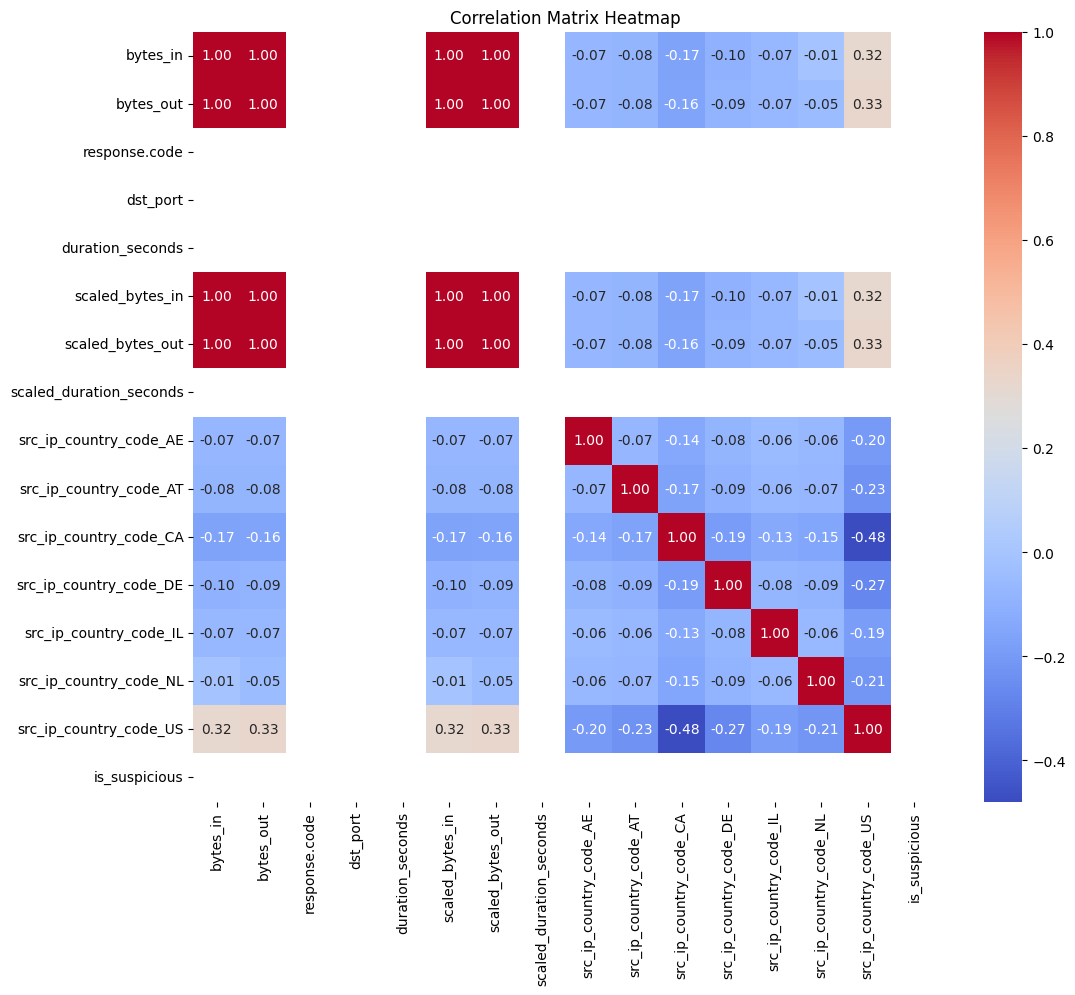

In [64]:
# Step 12: Heatmap for Correlation Analysis
numeric_df = df_transformed.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


<Figure size 1200x600 with 0 Axes>

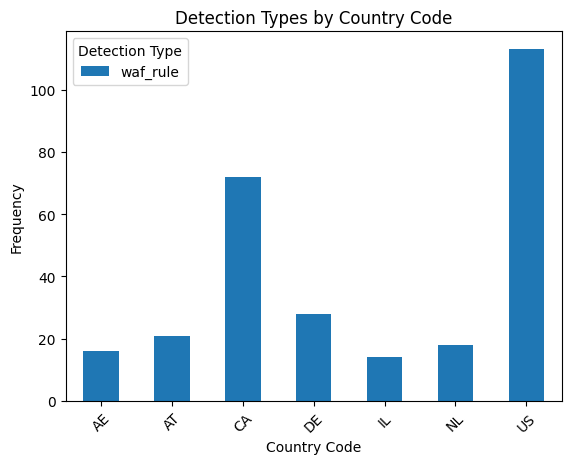

In [66]:
# Step 13: Stacked Bar Chart for Detection Types by Country
plt.figure(figsize=(12, 6))
detection_by_country = pd.crosstab(df_transformed['src_ip_country_code'], df_transformed['detection_types'])
detection_by_country.plot(kind='bar', stacked=True)
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Detection Type')
plt.show()